In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ADFTest
from prophet import Prophet
import statsmodels.api as sm

In [2]:
dfo = pd.read_csv('C:/Users/Admin/OneDrive/Pulpit/studia/III sem/Szeregi Czasowe/Projekt/AEP_hourly.csv')

In [3]:
dfo['Datetime'] = pd.to_datetime(dfo['Datetime'])
#df.set_index('Datetime', inplace = True)
#df.sort_index(inplace = True)

In [4]:
df = dfo.groupby(pd.Grouper(key='Datetime', axis=0, freq='W')).sum()

In [5]:
df.sort_index(inplace = True)

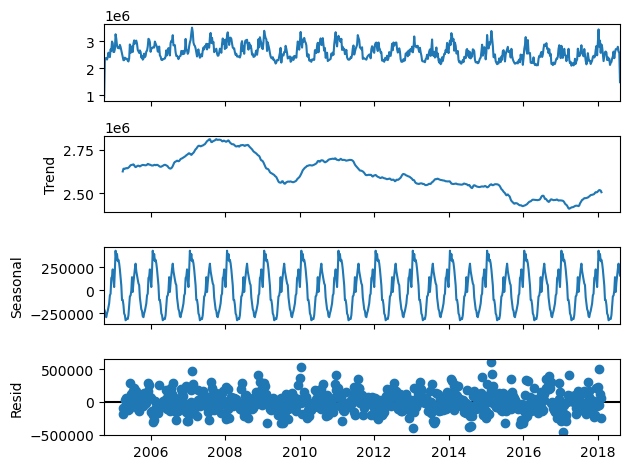

In [6]:
decomp_a = seasonal_decompose(df, model = 'additive', period = 52)
decomp_a.plot()
plt.show()

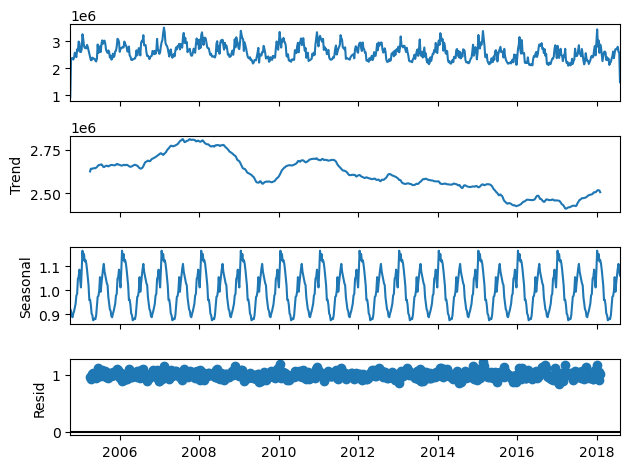

In [7]:
decomp_b = seasonal_decompose(df, model = 'multiplicative', period = 52)
decomp_b.plot()
plt.show()

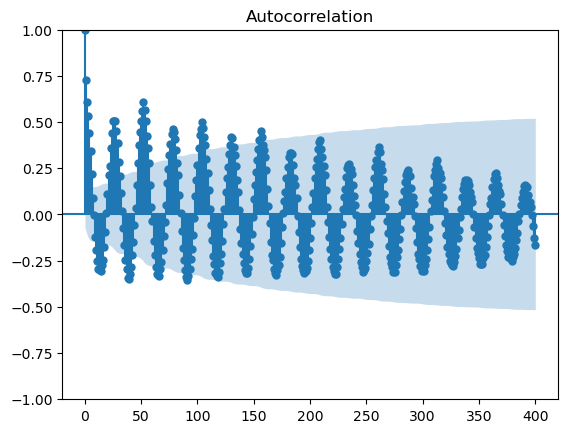

In [8]:
plot_acf(df, lags = 400)
plt.show()

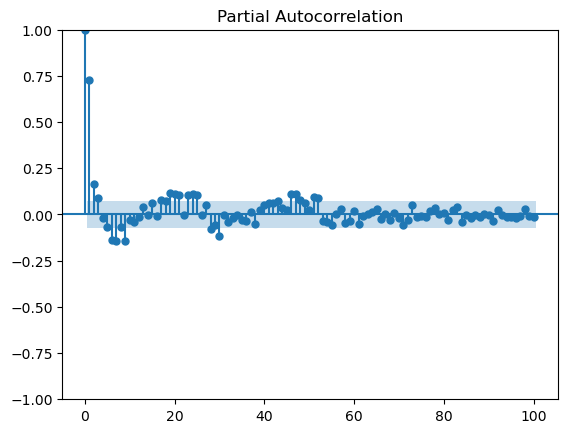

In [9]:
plot_pacf(df, lags = 100)
plt.show()

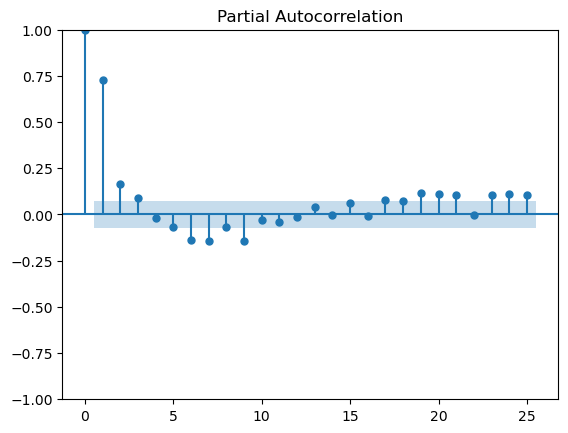

In [10]:
plot_pacf(df, lags = 25)
plt.show()

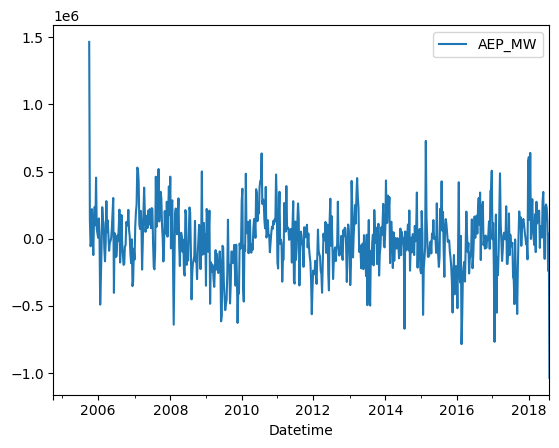

In [11]:
df.diff(52).plot()
plt.show()

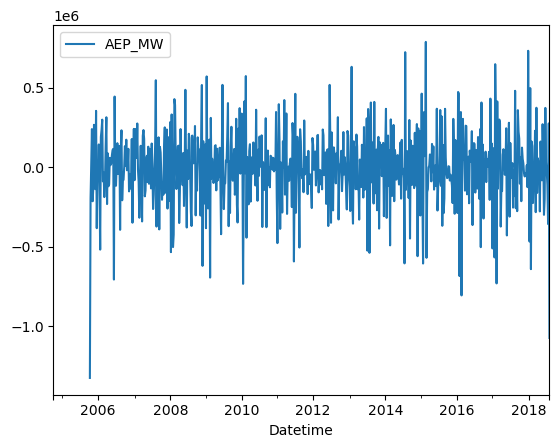

In [12]:
df.diff(1).diff(52).plot()
plt.show()

In [13]:
dfd = df.diff(1).diff(52)

In [14]:
dfd = dfd.dropna()

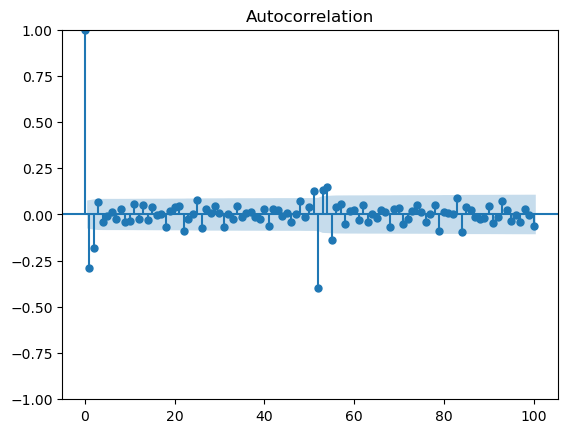

In [15]:
plot_acf(dfd, lags = 100)
plt.show()

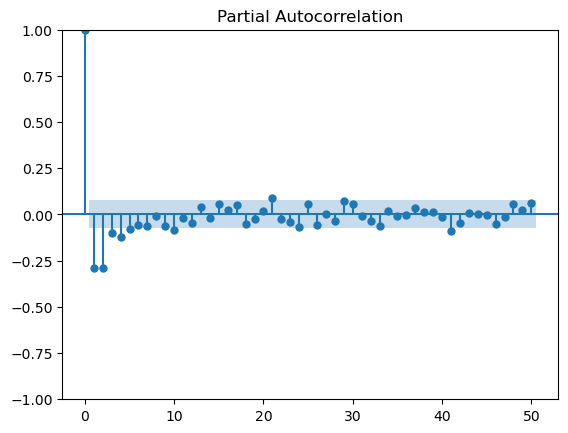

In [16]:
plot_pacf(dfd, lags = 50)
plt.show()

In [17]:
adt = adfuller(df)
print("p-value:", adt[1])
adf_test = ADFTest()
p_value, used_lag = adf_test.should_diff(df)
print("p-value:", p_value)

p-value: 0.019354737678678693
p-value: 0.01


In [18]:
data_train = df.loc['2005-01-01':'2017-12-31', :]
data_test = df.loc['2018-01-01':'2018-06-30', :]

In [19]:
model1 = SARIMAX(data_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 52))

In [20]:
model_fit = model1.fit(disp=False)

In [21]:
#model = auto_arima(data_train,start_p=1,start_q=1, d = 1, D = 1, max_p = 3, max_q = 3, start_P = 1, start_Q = 1, max_P = 3, max_Q = 3, test='adf',m=52,seasonal=True,trace=True)

In [22]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             AEP_MW   No. Observations:                  679
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -8466.839
Date:                            Sun, 19 Jan 2025   AIC                          16943.678
Time:                                    11:32:04   BIC                          16965.875
Sample:                                01-02-2005   HQIC                         16952.302
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3099      0.090      3.458      0.001       0.134       0.486
ma.L1         -0.6639      0.071     -9.395      0.000      -0.802      -0.525
ar.S.L52       0.1015      0.037      2.775      0.006       0.030       0.173
ma.S.L52      -0.7746      0.054    -14.467      0.000      -0.880      -0.670
sigma2      4.371e+10   4.56e-13   9.58e+22      0.000    4.37e+10    4.37e+10
===================================================================================
Ljung-Box (L1) (Q):                   2.64   Jarque-Bera (JB):                43.15
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.24
Prob(H) (two-sided):                  0.83   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.22e+39. Standard errors may be unstable.
"""

In [23]:
resid = model_fit.resid

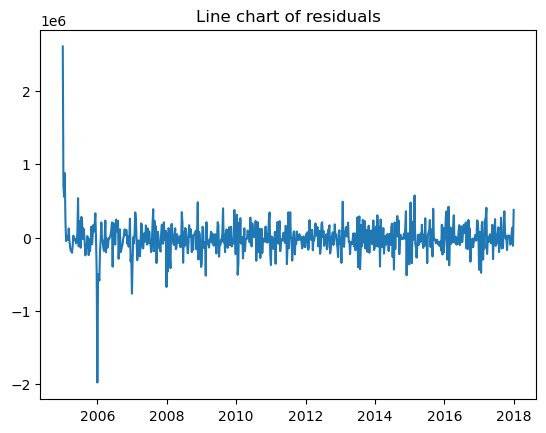

In [24]:
plt.plot(resid)
plt.title('Line chart of residuals')
plt.show()

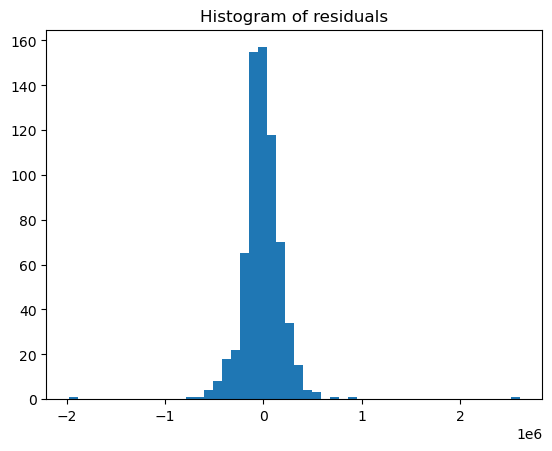

In [25]:
plt.hist(resid, bins =  50)
plt.title('Histogram of residuals')
plt.show()

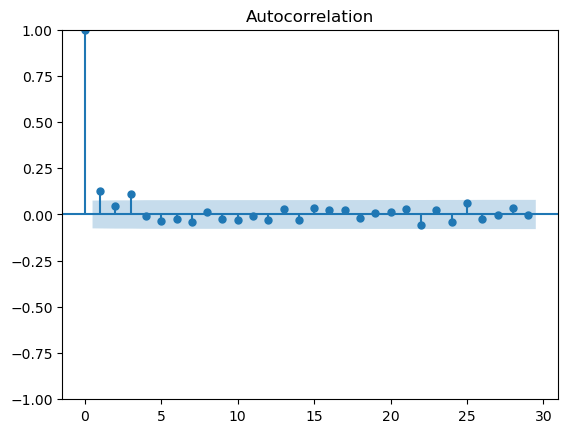

In [26]:
plot_acf(resid)
plt.show()

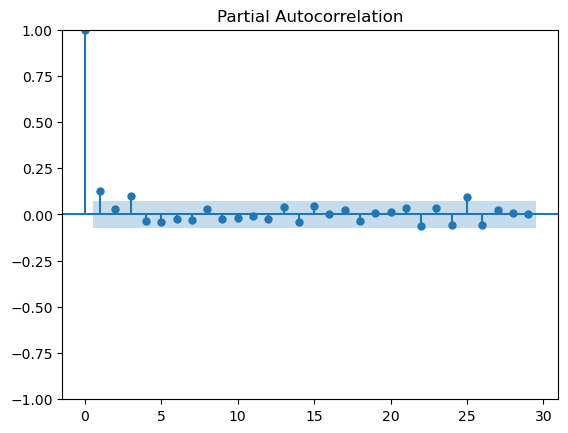

In [27]:
plot_pacf(resid)
plt.show()

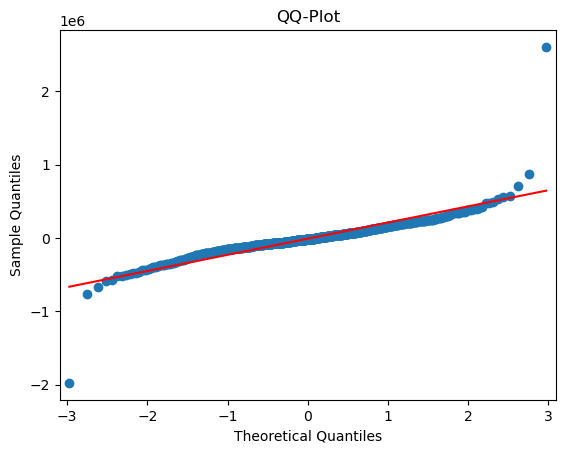

In [28]:
sm.qqplot(resid, line='s')
plt.title("QQ-Plot")
plt.show()

In [29]:
pred = model_fit.predict(start = '2018-01-01', end = '2018-06-30')

In [30]:
df_pred = pd.merge(data_test, pd.DataFrame(pred), left_index = True, right_index = True)

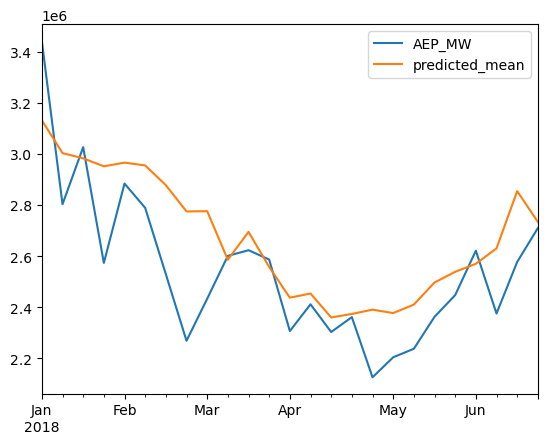

In [31]:
df_pred.plot()
plt.show()

In [32]:
RMSE = np.sqrt(np.mean((df_pred['AEP_MW'] - df_pred['predicted_mean'])**2))
RMSE_perc = RMSE/data_test['AEP_MW'].mean()

In [33]:
print(f'RMESE = {RMSE}')
print(f'Percentage deviation = {RMSE_perc}')

RMESE = 213688.64814898267
Percentage deviation = 0.083965663924144


In [69]:
### daily data - prophet

In [153]:
dfd = dfo.groupby(pd.Grouper(key='Datetime', axis=0, freq='D')).sum()

In [155]:
dfd.reset_index(inplace = True)

In [157]:
dfd.columns = ['ds', 'y']

In [201]:
data_train2 = dfd.set_index('ds').loc['2015-01-01':'2017-12-31', :].reset_index()
data_test2 = dfd.set_index('ds').loc['2018-01-01':'2018-01-31', :].reset_index()

In [209]:
model_p = Prophet(yearly_seasonality = True, weekly_seasonality = True, daily_seasonality = True)
model_p_fit = model_p.fit(data_train2)

11:46:14 - cmdstanpy - INFO - Chain [1] start processing
11:46:14 - cmdstanpy - INFO - Chain [1] done processing


In [211]:
future = model_p_fit.make_future_dataframe(periods=31)

In [215]:
df_pred2 = pd.merge(data_test2, model_p_fit.predict(future)[['ds', 'yhat']], left_on = 'ds', right_on = 'ds')

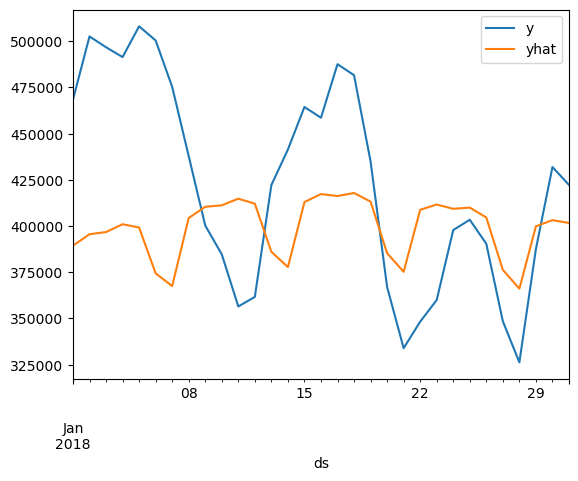

In [219]:
df_pred2.set_index('ds').loc['2018-01-01':'2018-01-31', :].plot()
plt.show()

In [221]:
RMSE2 = np.sqrt(np.mean((df_pred2['y'] - df_pred2['yhat'])**2))
RMSE_perc2 = RMSE/df_pred2['y'].mean()

In [223]:
print(f'RMESE = {RMSE2}')
print(f'Percentage deviation = {RMSE_perc2}')

RMESE = 60878.62172577756
Percentage deviation = 0.5060390410772613
